# Import

In [1]:
import comet_ml

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

In [3]:
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

In [4]:
import os.path as osp
import pickle

In [5]:
import pytorch_lightning as pl

In [6]:
# from beetl.task_datasets import BeetlSleepTutorial, BeetlSleepSource, BeetlSleepLeaderboard, BeetlMILeaderboard
# ds = BeetlSleepSource()
# path = ds.download()
# print(path)
# X, y, info = ds.get_data()

In [7]:
# BeetlSleepLeaderboard().download()

# Settings and utils

In [8]:
SEED=997
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
pl.seed_everything(SEED)

Global seed set to 997


997

In [9]:
hyper_params = {
    'max_epochs': 20,
    'learning_rate': 0.003,
    'weight_decay': 0.01,
    'scheduler_patience': 10,
    'batch_size': 256,
    'dropout_conv': 0.0,
    'dropout_fc': 0.1,
    'early_stop_patience': 20,
    'weight_beta': 0.995
}

In [10]:
def plot_label_distribution(y):
    (unique, counts) = np.unique(np.asarray(y), return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    plt.bar(unique, counts)
    plt.show()

In [11]:
# for i in range(39):
#     _, y, _ = dataset.get_data(subjects=[i])
#     plot_label_distribution(y)

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load train, validation data

## Train data and validation data

Train data and validation data are from the same set of data and are assumed to be from one distribution.

In [13]:
from beetl.task_datasets import BeetlSleepSource
dataset = BeetlSleepSource()
from sklearn.model_selection import train_test_split

# X_train, y_train, info = dataset.get_data(subjects=range(0, 35))
# X_test, y_test, _ = dataset.get_data(subjects=range(35, 39))

X, y, _ = dataset.get_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

(72436, 2, 3000)
[[    0 19257]
 [    1  6470]
 [    2 28763]
 [    3  4213]
 [    4  2400]
 [    5 11333]]


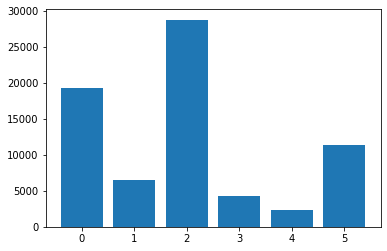

In [14]:
print(X_train.shape)
(unique, counts) = np.unique(np.asarray(y_train), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

In [15]:
loss_weight = np.power(hyper_params['weight_beta'], np.sqrt(frequencies[:,1]))
loss_weight = (1 - hyper_params['weight_beta']) / (1 - loss_weight)
loss_weight

array([0.00997568, 0.01506863, 0.00873161, 0.01800329, 0.02296356,
       0.01209129])

(18109, 2, 3000)
[[   0 4786]
 [   1 1471]
 [   2 7220]
 [   3 1034]
 [   4  657]
 [   5 2941]]


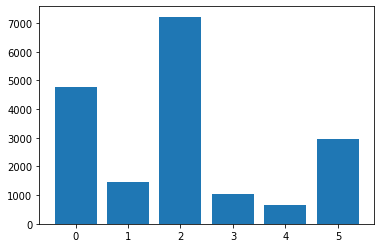

In [16]:
print(X_test.shape)
(unique, counts) = np.unique(np.asarray(y_test), return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
plt.bar(unique, counts)
plt.show()

In [17]:
X_train = np.delete(X_train, 1, 1)
X_test = np.delete(X_test, 1, 1)

From the above 2 histograms, we can see that they have similar labels' distribution.

In [18]:
%reset_selective -f "^X$"
%reset_selective -f "^y$"

# Dataloaders

In [19]:
from torch.utils.data import DataLoader, Dataset

class EEG1ChData(Dataset):
    def __init__(self, train_data, train_label, mode='train'):
        mean = np.mean(train_data, axis=2, keepdims=True)
        std = np.std(train_data, axis=2, keepdims=True)
        self.X = (train_data - mean) / std
        self.y = train_label
        self.mode = mode
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.mode == 'train':
#             shape = self.X[0].shape
#             noise = np.random.normal(0, 0.05, 6000).reshape(shape)
#             X = self.X[idx] + noise
            # randomly zero out 10 segments of length 50 to 10
            X = self.X[idx]
            zeroSegCount = np.random.randint(10)
            for i in range(zeroSegCount):
                s = np.random.randint(3000)
                l = np.random.randint(50, 100)
                for j in range(s, min(s + l, 3000)):
                    X[0][j] = 0
        else:
            X = self.X[idx]
        if self.y is not None:
            return torch.tensor(X, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)
        else:
            return torch.tensor(X, dtype=torch.float32)

In [20]:
train_dataset = EEG1ChData(X_train, y_train)
test_dataset = EEG1ChData(X_test, y_test, mode='test')
print(train_dataset.X.shape) # should be length, 1, 3000

(72436, 1, 3000)


(array([ 12.,  29., 149., 660., 844., 872., 349.,  58.,  15.,  12.]),
 array([-3.83410592, -3.02822537, -2.22234482, -1.41646427, -0.61058373,
         0.19529682,  1.00117737,  1.80705792,  2.61293846,  3.41881901,
         4.22469956]),
 <BarContainer object of 10 artists>)

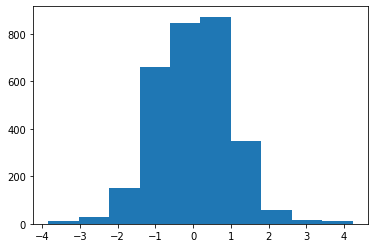

In [22]:
plt.hist(train_dataset.X[1][0])

In [24]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    shuffle=True,
    batch_size=hyper_params['batch_size'],
    pin_memory=True,
    num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=hyper_params['batch_size'], pin_memory=True, num_workers=2)

# Models

## Base Lightning Module

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from pytorch_metric_learning import losses as loss_fn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix

    
class BaseNet(pl.LightningModule):
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y, torch.tensor(loss_weight, device=self.device, dtype=torch.float))
        return {
            'loss': loss,
            'train_acc': torch.sum(torch.argmax(y_hat, axis=1) == y, dtype=torch.float32) / len(y)
        }
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in outputs]).mean()
        comet_logs = {'train_loss': avg_loss, 'train_acc': avg_acc}
        self.log_dict(comet_logs)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, axis=1)
        loss = F.cross_entropy(y_hat, y, torch.tensor(loss_weight, device=self.device, dtype=torch.float))
        return {
            'val_loss': loss,
            'val_acc': torch.sum(preds == y, dtype=torch.float32) / len(y),
            'preds': torch.tensor(preds),
            'y': torch.tensor(y)
        }

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        comet_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
        
        targets = []
        predicted = []
        for x in outputs:
            targets.extend(x['y'])
            predicted.extend(x['preds'])
            
        targets = F.one_hot(torch.tensor(targets))
        predicted = F.one_hot(torch.tensor(predicted))
        
        experiment = self.logger.experiment
        experiment.log_confusion_matrix(
            targets,
            predicted,
            title="Confusion Matrix, Epoch #%d" % (self.current_epoch + 1),
            file_name="confusion-matrix-%03d.json" % (self.current_epoch + 1),
        )
        self.log_dict(comet_logs)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return {
            'test_loss': loss,
            'test_acc': torch.sum(torch.argmax(y_hat, axis=1) == y, dtype=torch.float32) / len(y)
        }
    
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        comet_logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
        self.log_dict(comet_logs)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=hyper_params['weight_decay'])
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=hyper_params['scheduler_patience'], min_lr=1e-5),
                'interval': 'epoch',
                'frequency': 1,
                'monitor': 'val_loss',
            }
        }

## Models

In [27]:
# import torch.nn as nn
# import torch.nn.functional as F
    
# class LSTMNet(nn.Module):
#     def __init__(self, n_classes):
#         super(LSTMNet, self).__init__()
#         self.drop1 = nn.Dropout(0.5)
#         self.drop_ch = nn.Dropout2d(0.1)
#         self.fc = nn.Linear(128, n_classes)
#         self.n_classes = n_classes

#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=[10, 2], stride=1)
#         self.bn1 = nn.BatchNorm1d(16)
        
#         self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=10, stride=1)
#         self.bn2 = nn.BatchNorm1d(32)
        
#         self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=10, stride=1)
#         self.bn3 = nn.BatchNorm1d(64)
        
#         self.pool = nn.MaxPool1d(4)

#         self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

#         torch.nn.init.kaiming_normal_(self.conv1.weight)
#         torch.nn.init.kaiming_normal_(self.conv2.weight)
#         torch.nn.init.kaiming_normal_(self.conv3.weight)
#         torch.nn.init.kaiming_normal_(self.fc.weight)

#     def forward(self, x):
#         output = self.bn1(self.pool(F.relu(self.conv1(x)).reshape(x.shape[0], self.conv1.out_channels, -1)))
#         output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
        
#         output = self.bn2(self.pool(F.relu(self.conv2(output))))
#         output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
        
#         output = self.bn3(self.pool(F.relu(self.conv3(output))))
#         output = torch.squeeze(self.drop_ch(torch.unsqueeze(output, 3)))
#         # output's shape is batch, 64, 37
        
#         outputs, _ = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
# #         _, (outputs, _) = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
#         output = torch.mean(outputs, 1) # batch, hidden_size
# #         output = torch.squeeze(outputs)
#         output = F.relu(self.fc(self.drop1(output)))
#         return output


In [28]:
class WvNet(BaseNet):
    def __init__(self, learning_rate, drop_conv, drop_fc):
        super().__init__()
        
        self.learning_rate = learning_rate
        self.drop_fc = nn.Dropout(drop_fc)
        self.drop_conv = nn.Dropout2d(drop_conv)
        self.drop_sm = nn.Dropout(0.33)
        self.n_classes = 6
        self.conv_f_size = 16
        
        self.conv_fs = nn.ModuleList()
        for i in range(6):
            self.conv_fs.append(
                    nn.Sequential(OrderedDict([
                        ('conv', nn.Conv1d(in_channels=1, out_channels=self.conv_f_size, kernel_size=[5 * (2**i)], stride=1, bias=False)),
                        ('act', nn.ReLU()),
                        ('pool', nn.AdaptiveAvgPool1d((64))),
                        ('bn', nn.BatchNorm1d(self.conv_f_size))
                    ])
                )
            )

        self.pool_conv_1 = nn.AvgPool2d((2, 2))
        self.conv_gr1 = nn.Conv2d(in_channels=len(self.conv_fs), out_channels=16, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=1)
        self.bn_gr1 = nn.BatchNorm2d(self.conv_gr1.out_channels)
        
        self.conv_gr2 = nn.Conv2d(in_channels=self.conv_gr1.out_channels, out_channels=48, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=1)
        self.pool_conv_2 = nn.AvgPool2d((2, 1))
        self.bn_gr2 = nn.BatchNorm2d(self.conv_gr2.out_channels)
        
        self.conv_gr3 = nn.Conv2d(in_channels=self.conv_gr2.out_channels, out_channels=128, kernel_size=[4, 8], stride=1, groups=2)
        self.bn_gr3 = nn.BatchNorm2d(self.conv_gr3.out_channels)
        
        self.lstm = nn.LSTM(input_size=self.conv_gr3.out_channels, hidden_size=64, bidirectional=True, batch_first=True)
#         self.fc2 = nn.Linear(48, self.n_classes)
        
#         self.fc = nn.Linear(128, self.n_classes)
#         self.fc1 = nn.Linear(128, 48)
#
        # depthwise convolution acts as FC layer
        self.dw_conv = nn.Conv1d(in_channels=128, out_channels=6, kernel_size=[1], stride=1)

        
        for conv_f in self.conv_fs:
            torch.nn.init.kaiming_normal_(conv_f.conv.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr1.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr2.weight)
        torch.nn.init.kaiming_normal_(self.conv_gr3.weight)
        torch.nn.init.kaiming_normal_(self.dw_conv.weight)
#         torch.nn.init.kaiming_normal_(self.fc1.weight)
#         torch.nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        outputs = []
        for i in range(len(self.conv_fs)):
            output = self.conv_fs[i](x)
            output = self.drop_conv(output)
            output = torch.squeeze(output)
            outputs.append(output)
        
        output = torch.stack((outputs), dim=1)
        
        output = self.bn_gr1(self.pool_conv_1(F.relu(self.conv_gr1(output))))
        output = self.drop_conv(output)
        
        output = self.bn_gr2(self.pool_conv_2(F.relu(self.conv_gr2(output))))
        output = self.drop_conv(output)
        
        output = self.bn_gr3(F.relu(self.conv_gr3(output)))
        output = torch.squeeze(output)
        
#         _, (outputs, _) = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
#         output = outputs[1] # get hidden of backward pass

        outputs, _ = self.lstm(torch.transpose(output, 2, 1)) # batch, seq_len, hidden_size
        outputs = self.dw_conv(torch.transpose(outputs, 2, 1))
        output = torch.mean(outputs, dim=2) # batch, 6

#         output = F.relu(self.fc1(self.drop_fc(output)))
#         output = self.fc2(self.drop_fc(output))
        return output

    def configure_optimizers(self):
        optimizer = optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=hyper_params['weight_decay'])
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler.OneCycleLR(optimizer, max_lr=hyper_params['learning_rate'], steps_per_epoch=len(train_loader), epochs=hyper_params['max_epochs'], pct_start=0.3, div_factor=3),
                'interval': 'step',
                'frequency': 1,
                'monitor': 'val_loss',
            }
        }

In [29]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.optim import lr_scheduler
# from pytorch_metric_learning import losses as loss_fn
# from collections import OrderedDict
# from sklearn.metrics import confusion_matrix

    
# class WvConvNet(pl.LightningModule):
#     def __init__(self, learning_rate):
#         super().__init__()
#         self.learning_rate = learning_rate
#         self.drop_fc = nn.Dropout(0.2)
#         self.drop_conv = nn.Dropout2d(0.1)
#         self.n_classes = 6
#         self.conv_f_size = 16
        
#         self.conv_fs = nn.ModuleList()
#         for i in range(6):
#             self.conv_fs.append(
#                     nn.Sequential(OrderedDict([
#                         ('conv', nn.Conv2d(in_channels=1, out_channels=self.conv_f_size, kernel_size=[4, 2], stride=1, dilation=(2**i, 1), bias=False)),
#                         ('act', nn.ReLU()),
#                         ('pool', nn.AdaptiveAvgPool2d((32, 1))),
#                         ('bn', nn.BatchNorm2d(self.conv_f_size))
#                     ])
#                 )
#             )

#         self.pool_conv_2d = nn.MaxPool2d((2, 2))
#         self.conv_gr1 = nn.Conv2d(in_channels=len(self.conv_fs), out_channels=32, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=2)
#         self.bn_gr1 = nn.BatchNorm2d(self.conv_gr1.out_channels)
        
#         self.conv_gr2 = nn.Conv2d(in_channels=self.conv_gr1.out_channels, out_channels=64, kernel_size=[3, 7], stride=1, padding=(1, 3), groups=2)
#         self.bn_gr2 = nn.BatchNorm2d(self.conv_gr2.out_channels)
        
#         self.conv_gr3 = nn.Conv2d(in_channels=self.conv_gr2.out_channels, out_channels=128, kernel_size=[4, 8], stride=1, groups=2)
#         self.bn_gr3 = nn.BatchNorm2d(self.conv_gr3.out_channels)
        
#         self.fc = nn.Linear(self.conv_gr3.out_channels, self.n_classes)
    
#         for conv_f in self.conv_fs:
#             torch.nn.init.kaiming_normal_(conv_f.conv.weight)
#         torch.nn.init.kaiming_normal_(self.conv_gr1.weight)
#         torch.nn.init.kaiming_normal_(self.conv_gr2.weight)
#         torch.nn.init.kaiming_normal_(self.conv_gr3.weight)
#         torch.nn.init.kaiming_normal_(self.fc.weight)

#     def forward(self, x):
#         n_batch = x.shape[0]
#         outputs = []
#         for i in range(len(self.conv_fs)):
#             output = self.conv_fs[i](x)
#             output = self.drop_conv(output)
#             output = torch.squeeze(output)
#             outputs.append(output)
        
#         output = torch.stack((outputs), dim=1)
        
#         output = self.bn_gr1(self.pool_conv_2d(F.relu(self.conv_gr1(output))))
#         output = self.drop_conv(output)
        
#         output = self.bn_gr2(self.pool_conv_2d(F.relu(self.conv_gr2(output))))
#         output = self.drop_conv(output)
        
#         output = self.bn_gr3(F.relu(self.conv_gr3(output)))
#         output = self.drop_fc(torch.squeeze(output))

#         output = self.fc(output)
#         return output
    
#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = F.cross_entropy(y_hat, y)
#         return {
#             'loss': loss,
#             'train_acc': torch.sum(torch.argmax(y_hat, axis=1) == y, dtype=torch.float32) / len(y)
#         }
    
#     def training_epoch_end(self, outputs):
#         avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
#         avg_acc = torch.stack([x['train_acc'] for x in outputs]).mean()
#         comet_logs = {'train_loss': avg_loss, 'train_acc': avg_acc}
#         self.log_dict(comet_logs)
    
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         preds = torch.argmax(y_hat, axis=1)
#         loss = F.cross_entropy(y_hat, y)
#         return {
#             'val_loss': loss,
#             'val_acc': torch.sum(preds == y, dtype=torch.float32) / len(y),
#         }

#     def validation_epoch_end(self, outputs):
#         avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
#         avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
#         comet_logs = {'val_loss': avg_loss, 'val_acc': avg_acc}
#         self.log_dict(comet_logs)
    
#     def test_step(self, batch, batch_idx):
#         x, y = batch
#         y_hat = self(x)
#         loss = F.cross_entropy(y_hat, y)
#         return {
#             'test_loss': loss,
#             'test_acc': torch.sum(torch.argmax(y_hat, axis=1) == y, dtype=torch.float32) / len(y)
#         }
    
#     def test_epoch_end(self, outputs):
#         avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
#         avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
#         comet_logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
#         self.log_dict(comet_logs)
    
#     def configure_optimizers(self):
#         optimizer = optim.Adam(model.parameters(), lr=self.learning_rate, weight_decay=hyper_params['weight_decay'])
#         return {
#             'optimizer': optimizer,
#             'lr_scheduler': {
#                 'scheduler': lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=hyper_params['scheduler_patience'], min_lr=1e-6),
#                 'interval': 'epoch',
#                 'frequency': 1,
#                 'monitor': 'val_loss',
#             }
#         }

# Training

## Create trainer

In [31]:
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint

# arguments made to CometLogger are passed on to the comet_ml.Experiment class
comet_logger = CometLogger(
    api_key=comet_config['api_key'],
    workspace=comet_config['workspace'],
    project_name=comet_config['project_name'],
    experiment_name='WvNet f 1 channel + 5 * (2**i), len 64 + 3 layer + 16 features + lstm + dw_conv + random cut + weighted loss'
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=hyper_params['early_stop_patience'],
    min_delta=0.0005,
    verbose=False,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='../models/',
    filename='wvnet-1ch-{epoch}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(gpus=1, max_epochs=hyper_params['max_epochs'], logger=comet_logger, deterministic=True, callbacks=[lr_monitor, checkpoint_callback], stochastic_weight_avg=True)

CometLogger will be initialized in online mode
/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory ../models/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [32]:
trainer.logger.log_hyperparams(hyper_params)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/peara/sleep-eeg/a276306868f74d2e8c710378cad3569b



## Fit

In [33]:
model = WvNet(hyper_params['learning_rate'], hyper_params['dropout_conv'], hyper_params['dropout_fc'])

In [34]:
trainer.fit(model, train_loader, val_dataloaders=test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: Empty mapping given to log_params({}); ignoring

   | Name        | Type        | Params
---------------------------------------------
0  | drop_fc     | Dropout     | 0     
1  | drop_conv   | Dropout2d   | 0     
2  | drop_sm     | Dropout     | 0     
3  | conv_fs     | ModuleList  | 5.2 K 
4  | pool_conv_1 | AvgPool2d   | 0     
5  | conv_gr1    | Conv2d      | 2.0 K 
6  | bn_gr1      | BatchNorm2d | 32    
7  | conv_gr2    | Conv2d      | 16.2 K
8  | pool_conv_2 | AvgPool2d   | 0     
9  | bn_gr2      | BatchNorm2d | 96    
10 | conv_gr3    | Conv2d      | 98.4 K
11 | bn_gr3      | BatchNorm2d | 256   
12 | lstm        | LSTM        | 99.3 K
13 | dw_conv     | Conv1d      | 774   
---------------------------------------------
222 K     Trainable params
0         Non-trainable params
222 K     Total params
0.889     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
<ipython-input-26-610d57336b04>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'preds': torch.tensor(preds),
<ipython-input-26-610d57336b04>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'y': torch.tensor(y)
Global seed set to 997
/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_load

Training: 0it [00:00, ?it/s]

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/callback_hook.py:100: LightningDeprecationWarning: The signature of `Callback.on_train_epoch_end` has changed in v1.3. `outputs` parameter has been removed. Support for the old signature will be removed in v1.5
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/callbacks/stochastic_weight_avg.py:199: UserWarning: SWA is currently only supported every epoch. Found {'scheduler': <torch.optim.lr_scheduler.OneCycleLR object at 0x7fceec251730>, 'name': None, 'interval': 'step', 'frequency': 1, 'reduce_on_plateau': False, 'monitor': 'val_loss', 'strict': True, 'opt_idx': None}
  rank_zero_warn(f"SWA is currently only supported every epoch. Found {scheduler_cfg}")
Swapping scheduler <torch.optim.lr_scheduler.OneCycleLR object at 0x7fceec251730> for <torch.optim.swa_utils.SWALR object at 0x7fcfe2a0c8b0>


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/peara/sleep-eeg/a276306868f74d2e8c710378cad3569b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [1132]     : (0.28463658690452576, 1.5725730657577515)
COMET INFO:     lr-AdamW [21]   : (0.0008481747167074296, 0.002999999528461056)
COMET INFO:     train_acc [21]  : (0.7123841047286987, 0.8576430678367615)
COMET INFO:     train_loss [21] : (0.3973385989665985, 0.7945191264152527)
COMET INFO:     val_acc [21]    : (0.7655301094055176, 0.8193902969360352)
COMET INFO:     val_loss [21]   : (0.516021192073822, 0.64830482006073)
COMET INFO:   Others:
COMET INFO:     Name : WvNet f 1 channel + 5 * (2**i), len 64 + 3 layer + 16 features + lstm + dw_conv + random cut + weighted loss
COMET INFO:   Parameters:
COMET INFO:     batch_size       

In [35]:
%reset_selective -f "^train_loader$"
%reset_selective -f "^train_dataset$"

In [36]:
%reset_selective -f "^test_loader$"
%reset_selective -f "^test_dataset$"

## Test

### Test data

Test data is from a different set of subjects and have a different distribution.

In [37]:
from beetl.task_datasets import BeetlSleepLeaderboard
X_sleep_target, y_sleep_target, _, _ = BeetlSleepLeaderboard().get_data(subjects=range(0, 6))

(15442, 1, 3000)


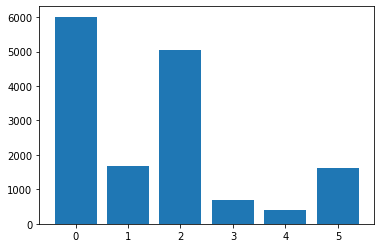

In [38]:
X_sleep_target = np.delete(X_sleep_target, 1, 1)
print(X_sleep_target.shape)
(unique, counts) = np.unique(y_sleep_target, return_counts=True)
plt.bar(unique, counts)
plt.show()

In [51]:
transfer_dataset = EEG1ChData(X_sleep_target, y_sleep_target, mode='test')
transfer_loader = torch.utils.data.DataLoader(dataset=transfer_dataset, batch_size=hyper_params['batch_size'], pin_memory=True, num_workers=2)

### Evaluate

In [40]:
trainer.test(model, transfer_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/peara/sleep-eeg/a276306868f74d2e8c710378cad3569b

/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7423436641693115, 'test_loss': 0.6673266887664795}
--------------------------------------------------------------------------------


[{'test_loss': 0.6673266887664795, 'test_acc': 0.7423436641693115}]

In [41]:
trainer.logger.experiment.end()

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/peara/sleep-eeg/a276306868f74d2e8c710378cad3569b
COMET INFO:   Metrics:
COMET INFO:     test_acc  : 0.7423436641693115
COMET INFO:     test_loss : 0.6673266887664795
COMET INFO:   Others:
COMET INFO:     Name : WvNet f 1 channel + 5 * (2**i), len 64 + 3 layer + 16 features + lstm + dw_conv + random cut + weighted loss
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET INFO: Uploading 1 metrics, params and output messages


In [42]:
%reset_selective -f "^transfer_loader$"
%reset_selective -f "^transfer_dataset$"

# TODO

In [ ]:
f = model.conv_fs[0].conv.weight[2][0].cpu().detach().numpy()
f

In [ ]:
from scipy import signal
t, y = signal.impulse(([1.0], f))
import matplotlib.pyplot as plt
plt.plot(t, y)

In [ ]:
plt.plot(f)

In [ ]:
trainer.save_checkpoint("../models/wvnet.ckpt")

# Submission

In [43]:
from beetl.task_datasets import BeetlSleepLeaderboard
_, _, X_sleep_test, _ = BeetlSleepLeaderboard().get_data(subjects=range(6, 18))

In [52]:
X_sleep_test = np.delete(X_sleep_test, 1, 1)
submission_dataset = EEG1ChData(X_sleep_test, None, mode='test')
submission_loader = torch.utils.data.DataLoader(dataset=submission_dataset, batch_size=128)

In [46]:
trainer = pl.Trainer(gpus=1, deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [47]:
model = WvNet.load_from_checkpoint(CHECKPOINT_PATH, learning_rate=0.01, drop_conv=0, drop_fc=0)

In [53]:
predicts = trainer.predict(model, submission_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/peara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [54]:
predicted_labels = []
for predicts in predicts:
    predicted_labels.extend(np.argmax(predicts.cpu().detach().numpy(), axis=1))

In [55]:
print(predicted_labels[:20])
np.savetxt("answer.txt",predicted_labels,delimiter=',',fmt="%d")

[5, 5, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 5, 1, 0, 5, 2, 2, 2, 0]


In [56]:
print(len(predicted_labels))

25748


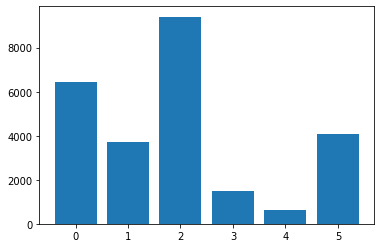

In [57]:
plot_label_distribution(predicted_labels)